Here is a "Hello, world" example to start showing aspects of writing for the Emu:
```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

// These are Emu-specific.
#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

long * ptr;
char * str_out;

int main (void)
{
     // long is the reliable word length, 64-bits.
     const long n = strlen (str) + 1;

     ptr = mw_malloc1dlong (n); // striped across the nodelets
     str_out = malloc (n * sizeof (char))); // entirely on the first nodelet

     starttiming(); // For the simulator.  Start gathering stats here.

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          str_out[k] = (char)ptr[k]; // Migration and remote write...

     printf("%s\n", str_out);  // Migration back
}
```

But where does `ptr` itself live? Does computing `ptr[k]` cause a migration?

An improved version, in hello-world/hello-world.c, showing use of `replicated`:
```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

// These are Emu-specific.
#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     // long is the reliable word length, 64-bits.
     const long n = strlen (str) + 1;

     /* Allocating a copy on each nodelet reduces migrations in theory.
        In *this* case, the pointers stay in registers and do not trigger migration.
        But that's up to compiler register allocation... */
     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming(); // For the simulator.  Start gathering stats here.

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          str_out[k] = (char)ptr[k]; // Migration and remote write

     printf("%s\n", str_out);  // Migration back
}
```
Let's compile and simulate this one.

In [2]:
!emu-cc -o hello-world.mwx hello-world/hello-world.c

In [3]:
!ls hello-world.*

hello-world.ipynb  hello-world.mwx


In [4]:
!emusim.x --capture_timing_queues -- hello-world.mwx


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:10:51 2019

End untimed simulation with local date and time= Sun Apr 14 00:10:51 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:10:51 2019

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.


In [5]:
!ls hello-world.*

hello-world.cdc    hello-world.mwx  hello-world.vsf
hello-world.ipynb  hello-world.tqd


In [6]:
!make_cdc_plots.py hello-world.cdc
!make_tqd_plots.py hello-world.tqd

Generating hello-world_migration_map.png
Generating hello-world_local_memops.png
Generating hello-world_remotes_map.png
Generating hello-world_live_threads.png
Generating hello-world_DDR.png
Generating hello-world_NLET_REGSETS_USED.png


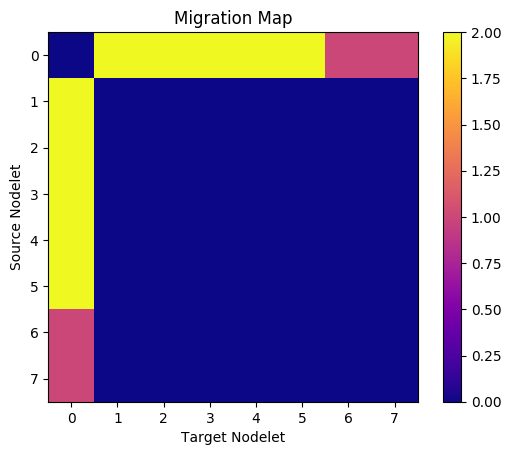

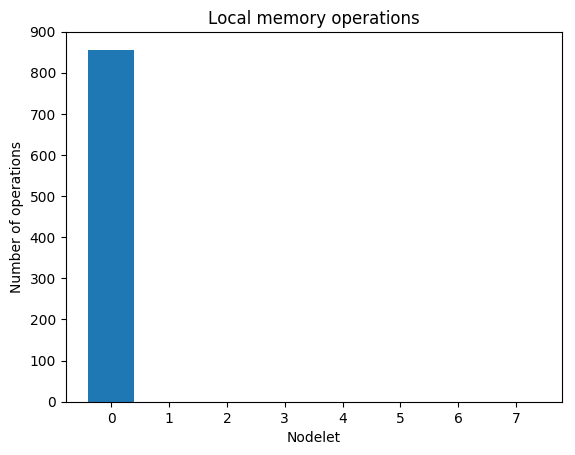

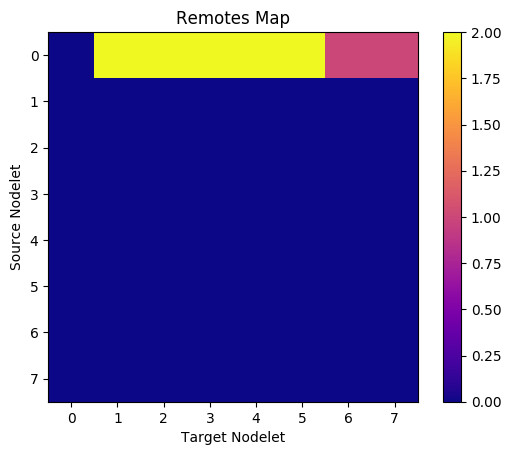

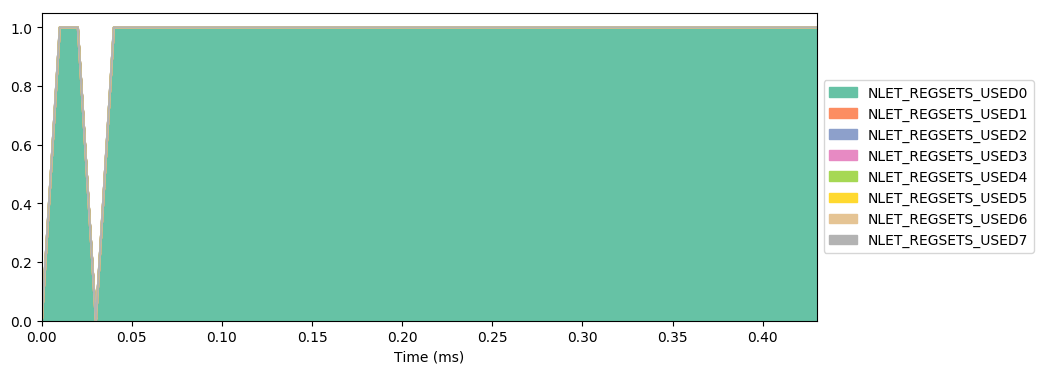

In [7]:
from IPython.display import Image, display
display(Image(filename="hello-world_migration_map.png"))
display(Image(filename="hello-world_local_memops.png"))
display(Image(filename="hello-world_remotes_map.png"))
display(Image(filename="hello-world_NLET_REGSETS_USED.png"))

That example kept one thread alive and migrating between nodelets.  This one, hello-world-spawn.c, uses Cilk's thread spawning intrinsic:
```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k)
          cilk_spawn copy_ptr (&str_out[k], &ptr[k]);

     printf("%s\n", str_out);  // Migration back
}
```

In [8]:
!emu-cc -o hello-world-spawn.mwx hello-world/hello-world-spawn.c
!emusim.x --capture_timing_queues  -- hello-world-spawn.mwx
!ls hello-world-spawn*
!make_cdc_plots.py hello-world-spawn.cdc
!make_tqd_plots.py hello-world-spawn.tqd


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:11:20 2019

End untimed simulation with local date and time= Sun Apr 14 00:11:20 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:11:20 2019

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.
hello-world-spawn.cdc  hello-world-spawn.tqd
hello-world-spawn.mwx  hello-world-spawn.vsf
Generating hello-world-spawn_migration_map.png
Generating hello-world-spawn_local_memops.png
Generating hello-world-spawn_remotes_map.png
Generating hello-world-spawn_live_threads.png
Generating hello-world-spawn_DDR.png
Generating hello-world-spawn_NLET_REGSETS_USED.png


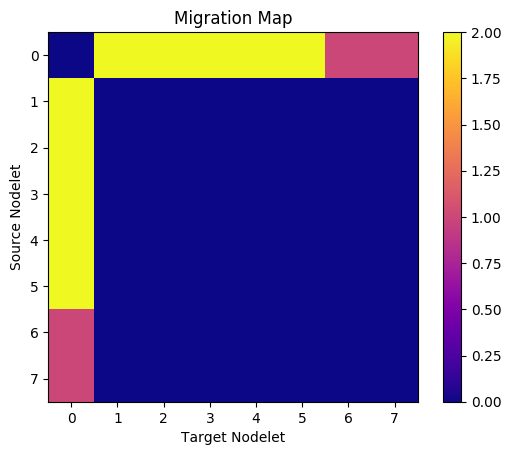

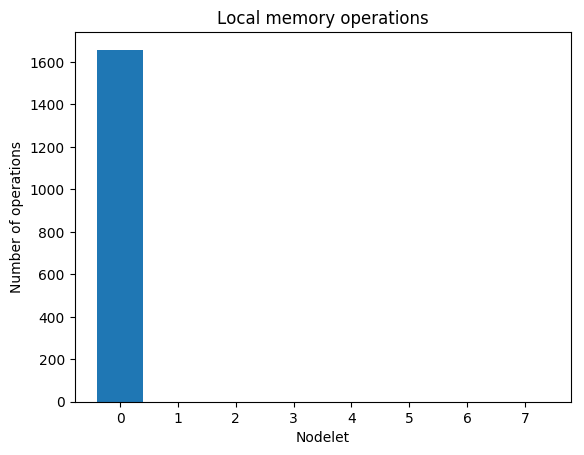

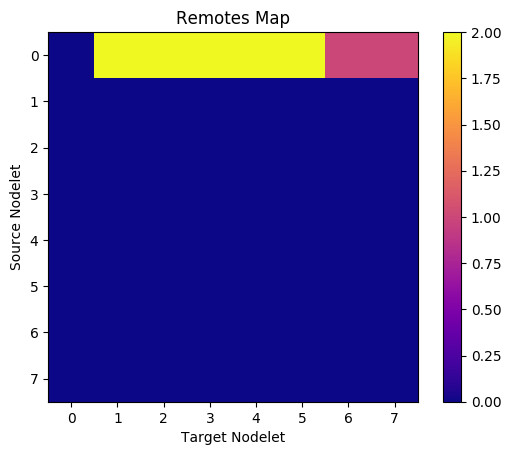

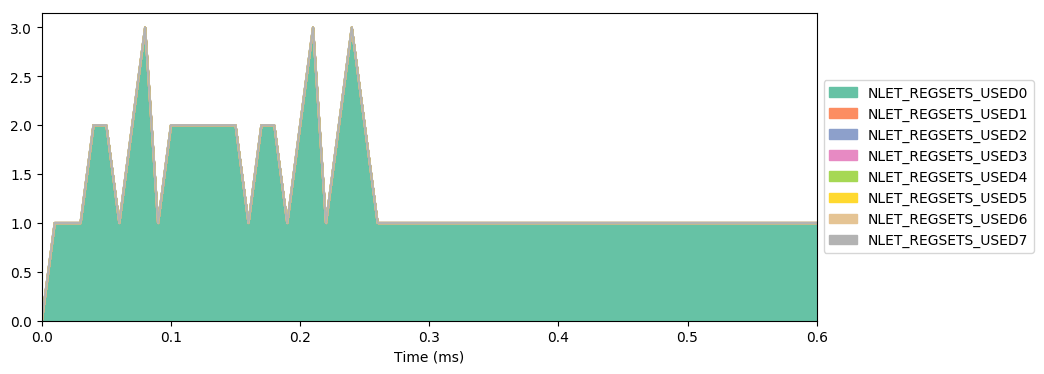

In [9]:
display(Image(filename="hello-world-spawn_migration_map.png"))
display(Image(filename="hello-world-spawn_local_memops.png"))
display(Image(filename="hello-world-spawn_remotes_map.png"))
display(Image(filename="hello-world-spawn_NLET_REGSETS_USED.png"))

And one interesting variation, hello-world-spawn-at.c, using an Emu extension still under development...
```c
#include <stdlib.h>
#include <stdio.h>
#include <string.h>
#include <cilk.h>

#include <memoryweb.h>
#include <timing.h>

static const char str[] = "Hello, world!";

static inline void copy_ptr (char *pc, const long *pl) { *pc = (char)*pl; }

replicated long * ptr;
replicated char * str_out;

int main (void)
{
     long n = strlen (str) + 1;

     mw_replicated_init ((long*)&ptr, (long)mw_malloc1dlong (n));
     mw_replicated_init ((long*)&str_out, (long)malloc (n * sizeof (char)));

     starttiming();

     for (long k = 0; k < n; ++k)
          ptr[k] = (long)str[k]; // Remote writes

     for (long k = 0; k < n; ++k) {
          cilk_spawn_at(&ptr[k]) copy_ptr (&str_out[k], &ptr[k]);
     }

     printf("%s\n", str_out);  // Migration back
}
```

In [10]:
!emu-cc -o hello-world-spawn-at.mwx hello-world/hello-world-spawn-at.c
!emusim.x --capture_timing_queues  -- hello-world-spawn-at.mwx
!ls hello-world-spawn-at*
!make_cdc_plots.py hello-world-spawn-at.cdc
!make_tqd_plots.py hello-world-spawn-at.tqd

 [Warning] Function call argument will be part of the spawn. Check for side-effects or move out of the spawn call.
28:           cilk_spawn_at(&ptr[k]) copy_ptr (&str_out[k], &ptr[k]);


        SystemC 2.3.1-Accellera --- Feb 15 2019 08:53:31
        Copyright (c) 1996-2014 by all Contributors,
        ALL RIGHTS RESERVED
Start untimed simulation with local date and time= Sun Apr 14 00:11:49 2019

End untimed simulation with local date and time= Sun Apr 14 00:11:49 2019

SysC Enumeration done. Program launching...
Simulation @0 s with local date and time= Sun Apr 14 00:11:49 2019

Hello, world!

Info: /OSCI/SystemC: Simulation stopped by user.
hello-world-spawn-at.cdc  hello-world-spawn-at.tqd
hello-world-spawn-at.mwx  hello-world-spawn-at.vsf
Generating hello-world-spawn-at_migration_map.png
Generating hello-world-spawn-at_local_memops.png
Generating hello-world-spawn-at_remotes_map.png
Generating hello-world-spawn-at_live_threads.png
Generating hello-world-spawn-at_DDR.png
Generatin

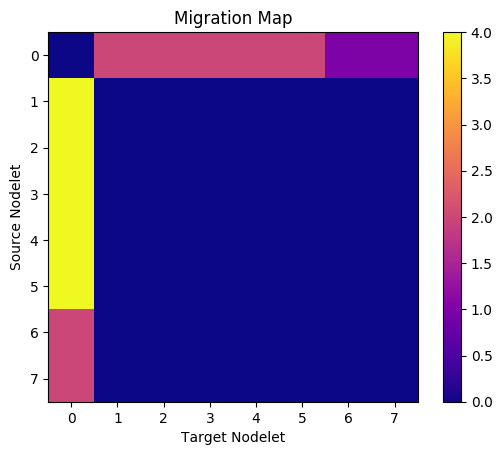

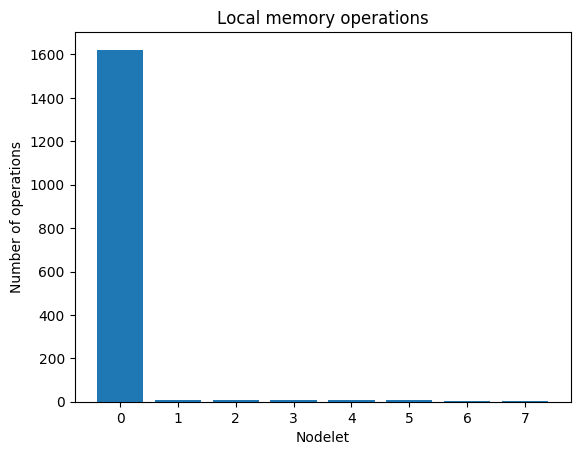

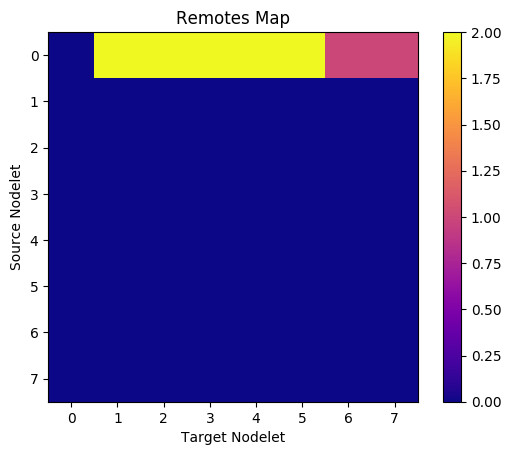

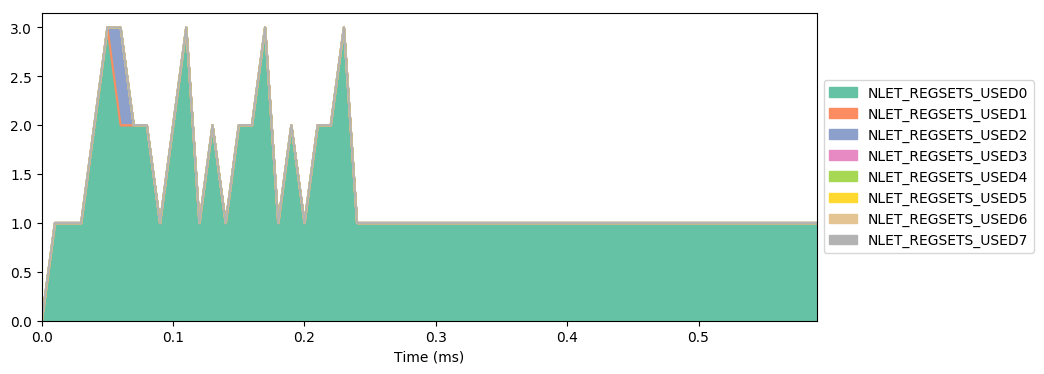

In [11]:
display(Image(filename="hello-world-spawn-at_migration_map.png"))
display(Image(filename="hello-world-spawn-at_local_memops.png"))
display(Image(filename="hello-world-spawn-at_remotes_map.png"))
display(Image(filename="hello-world-spawn-at_NLET_REGSETS_USED.png"))